In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jax.scipy.linalg import solve_triangular
from pykronecker import KroneckerProduct, KroneckerDiag
from jax.scipy.special import expit

from kreg.utils import cartesian_prod
from kreg.kernel.factory import vectorize_kfunc
from kreg.kernel.kron_kernel import KroneckerKernel
from kreg.likelihood import LogisticLikelihood
from kreg.model import KernelRegModel


plt.style.use("ggplot")

Using Jax backend with device TFRT_CPU_0


In [2]:
age_grid = jnp.arange(0, 101, 1)
location_ids = jnp.arange(0, 1000)
location_signature = jnp.vstack([location_ids % 10, location_ids % 100, location_ids]).T

full_X = cartesian_prod(location_ids, age_grid)


exp_a = 0.66
exp_b = 0.0


def k_region_single(x, y):
    return jnp.power(exp_a, jnp.sum(x != y) + exp_b)


def get_gaussianRBF(gamma):
    def f(x, y):
        return jnp.exp(-jnp.sum((x - y) ** 2) / (2 * gamma**2))

    return f


gamma = 10
k_age_rbf = get_gaussianRBF(gamma)


def k_age_single(x, y):
    return k_age_rbf(x, y) + 1.0 + 1e-8 * (x == y).all()


def k_combined_single(x, y):
    return k_region_single(x[0], y[0]) * k_age_single(x[1], y[1])


k_combined = vectorize_kfunc(k_combined_single)
k_region = vectorize_kfunc(k_region_single)
k_age = vectorize_kfunc(k_age_single)

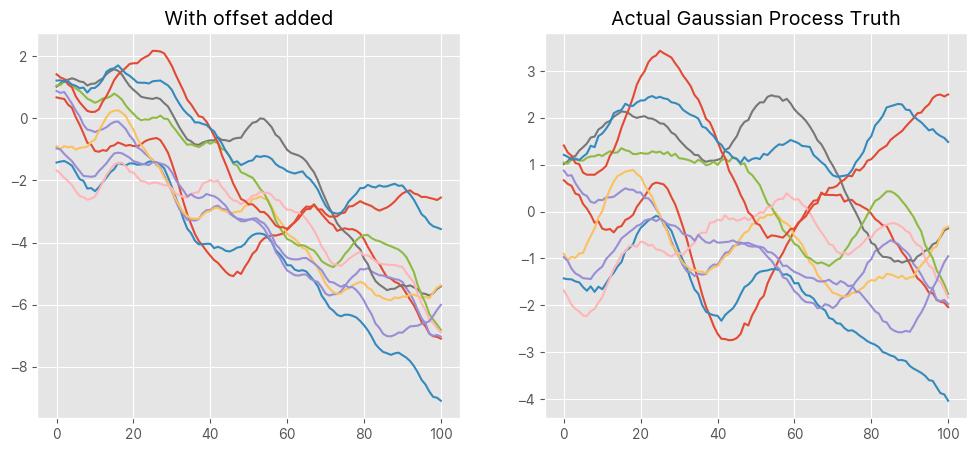

In [3]:
K_regions = k_region(location_signature, location_signature)
K_age = k_age(age_grid, age_grid)

K = KroneckerProduct([K_regions, K_age])
P = KroneckerProduct([jnp.linalg.inv(K_regions), jnp.linalg.inv(K_age)])

reg_eigval, reg_eigvec = jnp.linalg.eigh(K_regions)
age_eigval, age_eigvec = jnp.linalg.eigh(K_age)
left = KroneckerProduct([reg_eigvec, age_eigvec])

kronvals = jnp.outer(reg_eigval, age_eigval)


def P_beta(lam, beta):
    return left @ KroneckerDiag(kronvals / (lam + beta * kronvals)) @ left.T


cholreg = jnp.linalg.cholesky(K_regions)
cholreg_inv = solve_triangular(cholreg, jnp.identity(len(K_regions)))

cholage = jnp.linalg.cholesky(K_age + 1e-3 * jnp.identity(len(K_age)))
cholage_inv = solve_triangular(cholage, jnp.identity(len(K_age)), lower=True)

chol_K = KroneckerProduct([cholreg, cholage])


# cholkron = jnp.kron(cholreg,cholage)
# cholkron_inv = jnp.kron(cholreg_inv,cholage_inv)

np.random.seed(12)
S = jnp.array(np.random.randn(len(location_ids) * len(age_grid)))
truth_sample_raw = chol_K @ S
offset = 0.2 * jnp.sin(full_X[:, 1] / 2) - 0.05 * full_X[:, 1]

offset_mat = offset.reshape(len(location_ids), len(age_grid))
truth_sample = truth_sample_raw + offset
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
truth_mat = truth_sample.reshape(len(location_ids), len(age_grid))
plt.title("With offset added")
for i in range(jnp.minimum(len(location_ids), 10)):
    plt.plot(truth_mat[i])
plt.subplot(1, 2, 2)
plt.title("Actual Gaussian Process Truth")
for i in range(jnp.minimum(len(location_ids), 10)):
    plt.plot(truth_mat[i] - offset_mat[i])
plt.show()

num_per_location = 80
sample_size_lower = 50
sample_size_upper = 100
observed_indices = jnp.vstack(
    [
        i * len(age_grid)
        + np.random.choice(len(age_grid), num_per_location, replace=False)
        for i in range(len(location_ids))
    ]
).flatten()

sample_sizes_observed = np.random.choice(
    range(sample_size_lower, sample_size_upper), len(observed_indices)
)
probs_observed = expit(truth_sample[observed_indices])

In [4]:
offset = jnp.array(offset)

sample_sizes = jnp.zeros(len(location_signature) * len(age_grid))
sample_sizes = sample_sizes.at[observed_indices].set(sample_sizes_observed).astype(int)
prob_vals = jnp.zeros(len(location_signature) * len(age_grid))
prob_vals = prob_vals.at[observed_indices].set(probs_observed)
obs_counts = np.random.binomial(sample_sizes, prob_vals)

kernels = [k_region, k_age]

In [5]:
kernel = KroneckerKernel(kernels, [location_signature, age_grid], nugget=0.005)
likelihood = LogisticLikelihood(obs_counts, sample_sizes)
lam = 1.0
model = KernelRegModel(kernel, likelihood, lam, offset)
y_opt, conv = model.optimize(
    grad_tol=5e-4,
    max_newton_cg=100,
    max_cg_iter=50,
    nystroem_rank=50,
    scaling_cg_iter=2,
)

  0%|          | 0/100 [00:00<?, ?it/s]

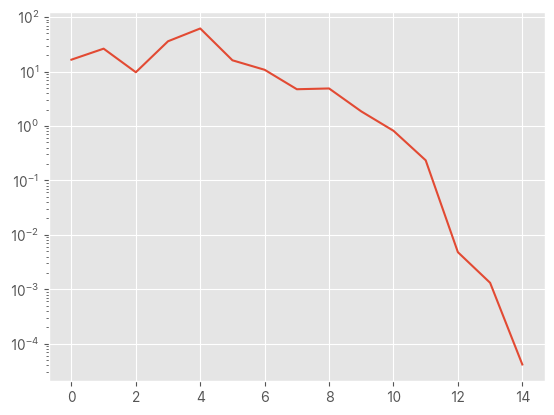

In [6]:
plt.plot(conv["iterate_maxnorm_distances"])
plt.yscale("log")

In [7]:
jnp.mean((y_opt - truth_sample_raw) ** 2) / jnp.var(truth_sample_raw)

Array(0.0431495, dtype=float64)